In [1]:
## Test trained GAN models 
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from numpy.random import randn
import tensorflow as tf
import cv2
import numpy as np

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Overlay trajectories (data_y) to the image (data_x)
def create_trajectory(data_x, data_y, obs_len=10):
    # Calibration parameter to overlay for a 1280x360 resolution image
    K = np.array([[537.023764, 0, 640 , 0], 
                    [0 , 537.023764, 180, 0], 
                    [0, 0, 1, 0]])
    # Rotation matrix to obtain egocentric trajectory
    Rt = np.array([[0.028841, 0.007189, 0.999558, 1.481009],
                    [-0.999575,  0.004514,  0.028809,  0.296583],
                    [ 0.004305,  0.999964, -0.007316, -1.544537],
                    [ 0.      ,  0.      ,  0.      ,  1.      ]])

    # Resize data back to 1280x360
    data_x = cv2.resize(data_x, (1280,360))
    # Add column of ones for rotation matrix multiplication
    data_y = np.hstack((data_y, np.ones((len(data_y),1))))
    # Draw points
    for m in range(obs_len, data_y.shape[0]):
        # Rotation matrix multiplication of trajectory 
        A = np.matmul(np.linalg.inv(Rt), data_y[m, :].reshape(4, 1))
        # Egocentric view of trajectory
        B = np.matmul(K, A)
        # Circle location of trajectories 
        x = int(B[0, 0] * 1.0 / B[2, 0])
        y = int(B[1, 0] * 1.0 / B[2, 0])
        if (x < 0 or x > 1280 - 1 or y > 360 - 1):
            continue
        # Use opencv to overlay trajectories
        data_x = cv2.circle(data_x, (x, y), 3, (0, 0, 255), -1)
    return data_x

In [4]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [5]:
# plot source, generated and target images
def plot_images(X_realA, X_fakeB, X_realB, filename, n_samples=1):
    X_realA = (X_realA + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    pyplot.figure(figsize=(32.0, 20.0))
    # plot real source images
    for i in range(n_samples):
        orig_image = (X_realA[i]* 255).astype(np.uint8)
        orig_image = cv2.resize(orig_image, (1280,360))
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(orig_image)
        pyplot.title(titles[i])
    # plot generated target image
    for i in range(n_samples):
        fake_sample = create_trajectory((X_realA[i]* 255).astype(np.uint8), X_fakeB[i])
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(fake_sample)
        pyplot.title(titles[1 + i])
    # plot real target image
    for i in range(n_samples):
        true_sample = create_trajectory((X_realA[i]* 255).astype(np.uint8), X_realB[i])
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(true_sample)
        pyplot.title(titles[i + 2])
    # save plot to file
    pyplot.subplots_adjust(hspace=0.4)
    pyplot.savefig(filename)
    pyplot.show()
    # save the generator model

In [6]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	return [X1, X2]

In [7]:
# load dataset
[X1, X2] = load_real_samples('dataset.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (19031, 256, 256, 3) (19031, 40, 3)


In [8]:
# load model
model = load_model('./model_038062.h5')

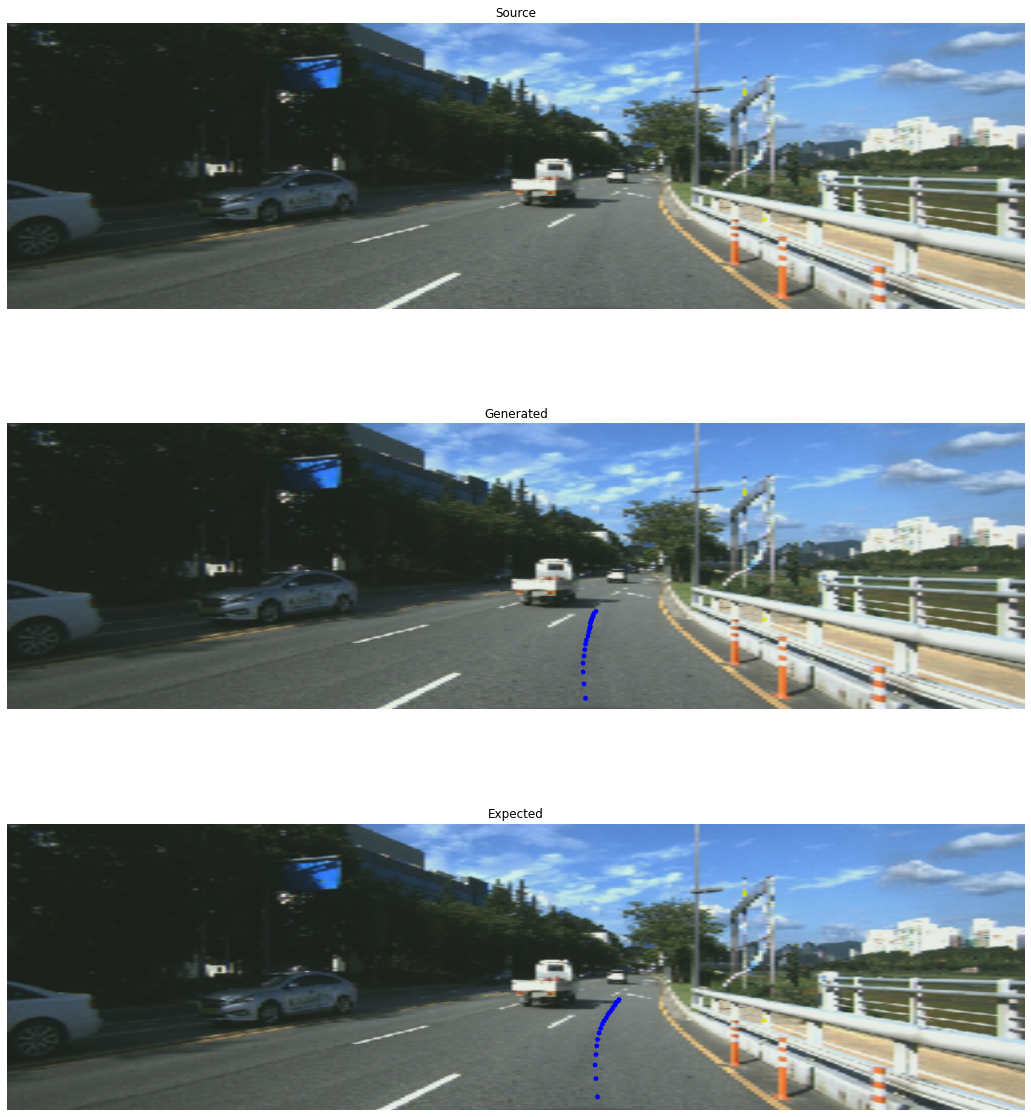

In [9]:
# select random example
latent_dim = 512
z_input = generate_latent_points(latent_dim, 1)
#ix = int(randint(0, len(X1), 1))
ix = 4290
src_image, tar_traj = X1[ix].reshape((1, 256, 256, 3)), X2[ix].reshape((1,40,3))
# generate image from source
gen_traj = model.predict([src_image, z_input])
plot_images(src_image, gen_traj, tar_traj, 'sample6.png')

In [10]:
import math
def euclidean_distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 + (p2[2] - p1[2])**2)

In [11]:
#params: traj1, traj2 - sets of two trajectories which the ADE is requires
#returns: Average Displacement Error between two trajectories
#brief: takes two traj. of same size, returns the average euclidean distance between all points of traj1 and traj2
def ADE(traj1, traj2):
    try:
        assert(traj1.shape == traj2.shape)
    except AssertionError:
        print("trajectory arrays differ in size!")
        return None
    dist = []
    points = len(traj1[0])
    #print(f'{points} long')
    for itr in range(points):
        p1 = traj1[0][itr]
        p2 = traj2[0][itr]
        dist.append(euclidean_distance(p1, p2))
        #print(f'traj1: {p1}, traj2: {p2}, dist: {dist[itr]}')
    ade = sum(dist)/len(dist)
    #print(ade)
    return ade

In [12]:
#params: traj1, traj2 - sets of two trajectories which the FDE is requires
#returns: Final Displacement Error between two trajectories
#brief: takes two traj. of same size, returns the euclidean distance between final points of traj1 and traj2
def FDE(traj1, traj2):
    try:
        assert(traj1.shape == traj2.shape)
    except AssertionError:
        print("trajectory arrays differ in size!")
        return None
    last_idx = len(traj1[0]) - 1
    #print(f'last index is {last_idx}')
    p1 = traj1[0][last_idx]
    p2 = traj2[0][last_idx]
    fde = euclidean_distance(p1, p2)
    #print(f'traj1: {p1}, traj2: {p2}, dist: {fde}')
    #print(fde)
    return fde

In [13]:
def get_stats(num_trajs=100, latent_dim=512, z_input=generate_latent_points(latent_dim, 1)):
    minADE = float('inf')
    minFDE = float('inf')
    avgADE = []
    avgFDE = []
    for img in range(num_trajs):
        ix = img
        src_image, tar_traj = X1[ix].reshape((1, 256, 256, 3)), X2[ix].reshape((1,40,3))
        # generate image from source
        gen_traj = model.predict([src_image, z_input])
        #plot_images(src_image, gen_traj, tar_traj, 'sample6.png')
        fde = FDE(tar_traj, gen_traj)
        ade = ADE(tar_traj, gen_traj)
        print(f'image: {img}, FDE: {fde}, ADE: {ade}')
        
        #minADE
        minADE = ade if ade < minADE else minADE
        
        #minFDE
        minFDE = fde if fde < minFDE else minFDE
        
        #avgADE
        avgADE.append(ade)
        
        #avgFDE
        avgFDE.append(fde)
        
    return(minADE, minFDE, sum(avgADE)/len(avgADE), sum(avgFDE)/len(avgFDE))

In [14]:
%%time
minADE, minFDE, avgADE, avgFDE = get_stats(num_trajs=5000)
print(f'minADE = {minADE}')
print(f'minFDE = {minFDE}')
print(f'avgADE = {avgADE}')
print(f'avgFDE = {avgFDE}')

image: 0, FDE: 10.171575211848412, ADE: 4.317969893304147
image: 1, FDE: 5.08292342370688, ADE: 2.2207629127570305
image: 2, FDE: 3.275065227564291, ADE: 1.5001148569948903
image: 3, FDE: 1.9357605330467744, ADE: 0.9979168502811276
image: 4, FDE: 1.8856079410210629, ADE: 0.9594243607068924
image: 5, FDE: 2.1903631240444423, ADE: 1.077702072284766
image: 6, FDE: 2.8942312449938212, ADE: 1.3359649224942531
image: 7, FDE: 4.135373604081322, ADE: 1.8334330293896808
image: 8, FDE: 4.708639000480835, ADE: 2.0608524245155992
image: 9, FDE: 4.136291395133793, ADE: 1.8379914838070004
image: 10, FDE: 4.390983147445504, ADE: 1.9443771112682444
image: 11, FDE: 3.8893395038112684, ADE: 1.7463450630850184
image: 12, FDE: 3.255424957537439, ADE: 1.4864743531610205
image: 13, FDE: 3.239826674340423, ADE: 1.4811329550418013
image: 14, FDE: 4.170779607665231, ADE: 1.8667024062547455
image: 15, FDE: 2.8135226963703213, ADE: 1.3023494578207495
image: 16, FDE: 1.588910372272501, ADE: 0.8220132747568577
ima

image: 140, FDE: 0.5727234454595388, ADE: 0.44691480038633824
image: 141, FDE: 1.0873211848596263, ADE: 0.5955199335256236
image: 142, FDE: 1.5003718109824182, ADE: 0.7280151737280959
image: 143, FDE: 0.9153654391153668, ADE: 0.5631010819946025
image: 144, FDE: 0.9208098874409324, ADE: 0.5686657619539813
image: 145, FDE: 0.757284499347646, ADE: 0.5038850389654949
image: 146, FDE: 3.4361642634546437, ADE: 1.4898544116437287
image: 147, FDE: 0.8590898100952307, ADE: 0.5361218672841714
image: 148, FDE: 1.08906143160349, ADE: 0.6397454971884794
image: 149, FDE: 1.116717889509703, ADE: 0.6393266660952694
image: 150, FDE: 1.1185169512851876, ADE: 0.6307774711878988
image: 151, FDE: 1.800995921281016, ADE: 0.883662028074671
image: 152, FDE: 2.4050844149394135, ADE: 1.127472786016893
image: 153, FDE: 2.519195098718783, ADE: 1.1822303426845993
image: 154, FDE: 2.6842465275225567, ADE: 1.247694141305152
image: 155, FDE: 2.6546637150786765, ADE: 1.2493110037053639
image: 156, FDE: 2.7313076355754

image: 277, FDE: 10.249058447996916, ADE: 5.235754409177569
image: 278, FDE: 8.37191603208391, ADE: 4.445454078190917
image: 279, FDE: 8.201781836426576, ADE: 4.39126088205128
image: 280, FDE: 6.494348556402588, ADE: 3.6655312227157744
image: 281, FDE: 6.077243534368448, ADE: 3.4775882014473374
image: 282, FDE: 3.183569858497443, ADE: 2.121666436126275
image: 283, FDE: 3.6438908748251024, ADE: 2.3818237394153727
image: 284, FDE: 6.301564970701508, ADE: 3.556269208705822
image: 285, FDE: 6.885376438646634, ADE: 3.778890500935207
image: 286, FDE: 2.7625532038997105, ADE: 1.675088394839117
image: 287, FDE: 4.70873547551541, ADE: 2.8077154313713377
image: 288, FDE: 2.6941707066491194, ADE: 1.2820659715970764
image: 289, FDE: 3.7281100704939405, ADE: 2.3462072141884027
image: 290, FDE: 3.4099852374512154, ADE: 2.1975411304072123
image: 291, FDE: 2.7584706663555125, ADE: 1.8467340587642713
image: 292, FDE: 2.2505452748070245, ADE: 1.4251189200697851
image: 293, FDE: 2.7374288396298487, ADE: 

image: 415, FDE: 2.9593598544723934, ADE: 1.3666547810484155
image: 416, FDE: 1.0601897244480294, ADE: 0.698354381964178
image: 417, FDE: 0.46887850105141865, ADE: 0.5174159291852602
image: 418, FDE: 1.084814751576084, ADE: 0.7317370239988297
image: 419, FDE: 1.2287204198777069, ADE: 0.7742681953782153
image: 420, FDE: 1.3123086302289335, ADE: 0.8165919267812377
image: 421, FDE: 0.8160175584663953, ADE: 0.6366889401723423
image: 422, FDE: 0.5733736736534669, ADE: 0.5530510343139022
image: 423, FDE: 1.1170942892693752, ADE: 0.7121269640753791
image: 424, FDE: 0.6629047549868056, ADE: 0.5649124037827915
image: 425, FDE: 2.5598504225979077, ADE: 1.1813895085123385
image: 426, FDE: 5.099045193027307, ADE: 2.239125998817295
image: 427, FDE: 5.069660814389037, ADE: 2.218610020093199
image: 428, FDE: 4.349834444363801, ADE: 1.904001548563078
image: 429, FDE: 4.294073924250935, ADE: 1.8738530437336358
image: 430, FDE: 4.49816624335915, ADE: 1.947855141125256
image: 431, FDE: 4.202254814501327,

image: 554, FDE: 2.593946099770549, ADE: 1.1087964892307824
image: 555, FDE: 2.320923907173595, ADE: 0.9920332361200825
image: 556, FDE: 1.9134112784268862, ADE: 0.8796411220405543
image: 557, FDE: 1.8541057574493316, ADE: 0.8011463070784748
image: 558, FDE: 2.1854670998339873, ADE: 0.950505604657956
image: 559, FDE: 1.5648666753964575, ADE: 0.6984913105271445
image: 560, FDE: 2.7891980481406717, ADE: 1.220920113724188
image: 561, FDE: 3.2720199912450885, ADE: 1.434832139039303
image: 562, FDE: 3.1015143588624703, ADE: 1.3789894232209499
image: 563, FDE: 3.9529593019114215, ADE: 1.7598835447132555
image: 564, FDE: 2.3574927440436433, ADE: 1.0965651131825536
image: 565, FDE: 3.4477372508234088, ADE: 1.5704577367668353
image: 566, FDE: 2.8060989817092805, ADE: 1.3107994129790816
image: 567, FDE: 1.2606372124075946, ADE: 0.6765791987522056
image: 568, FDE: 2.121323974615386, ADE: 1.0527483233268717
image: 569, FDE: 1.3011476071439347, ADE: 0.7282175292550794
image: 570, FDE: 0.68860120046

image: 691, FDE: 0.01705248194123648, ADE: 0.018385409220784518
image: 692, FDE: 0.01696975858012593, ADE: 0.018963418093031408
image: 693, FDE: 0.016025871470930698, ADE: 0.018632014940242338
image: 694, FDE: 0.01601328014539311, ADE: 0.019131167882068298
image: 695, FDE: 0.014621440035425506, ADE: 0.01604663742341025
image: 696, FDE: 0.013968770742601737, ADE: 0.014526749869346281
image: 697, FDE: 0.015346148104608217, ADE: 0.015775845329778503
image: 698, FDE: 0.015127043848034994, ADE: 0.01580529461564814
image: 699, FDE: 0.015303184202343776, ADE: 0.0163382117377073
image: 700, FDE: 0.01580877905419733, ADE: 0.01737321567141202
image: 701, FDE: 0.0156621535009996, ADE: 0.017903559141715767
image: 702, FDE: 0.015607811914430324, ADE: 0.018575686788140883
image: 703, FDE: 0.014178443519860058, ADE: 0.018222107415809735
image: 704, FDE: 0.01251206531677451, ADE: 0.01747379684271734
image: 705, FDE: 0.008131778887908362, ADE: 0.014120590867384573
image: 706, FDE: 0.01104691950253288, 

image: 824, FDE: 4.808101359846793, ADE: 2.1391924380898244
image: 825, FDE: 4.1165594564591705, ADE: 1.854071550777487
image: 826, FDE: 3.834450984441212, ADE: 1.7364055779545187
image: 827, FDE: 3.8301892747391713, ADE: 1.7402795938607771
image: 828, FDE: 4.042007637011255, ADE: 1.827700553365159
image: 829, FDE: 4.113396726660729, ADE: 1.8610704816703474
image: 830, FDE: 3.8831572456955366, ADE: 1.7643890642816398
image: 831, FDE: 4.88875143067505, ADE: 2.181305826667505
image: 832, FDE: 5.3145742793316195, ADE: 2.3513613245240075
image: 833, FDE: 4.7704188874404965, ADE: 2.1115585951008624
image: 834, FDE: 5.2326359415734505, ADE: 2.3029436373459493
image: 835, FDE: 5.841109110187102, ADE: 2.583790581765669
image: 836, FDE: 5.315475945873492, ADE: 2.368557447610164
image: 837, FDE: 4.752661134033907, ADE: 2.1385233475015966
image: 838, FDE: 3.5381283475317518, ADE: 1.640823642688326
image: 839, FDE: 2.932278834769979, ADE: 1.4068050334059852
image: 840, FDE: 2.831713890964985, ADE:

image: 964, FDE: 0.31631024722386325, ADE: 0.3570520269832418
image: 965, FDE: 0.23171459862531713, ADE: 0.34196860865980294
image: 966, FDE: 0.1869180455622497, ADE: 0.3421211965237402
image: 967, FDE: 0.15928003560304513, ADE: 0.35527612423591115
image: 968, FDE: 0.035967576667225984, ADE: 0.3188531283083502
image: 969, FDE: 0.17264446064805325, ADE: 0.29544987572279413
image: 970, FDE: 0.3292970809318533, ADE: 0.27714836657862596
image: 971, FDE: 0.5855802271223706, ADE: 0.25027193199378484
image: 972, FDE: 0.7849457369481165, ADE: 0.2521612255523143
image: 973, FDE: 1.044912272321001, ADE: 0.26586010922761066
image: 974, FDE: 1.2820593569361132, ADE: 0.2938894127322715
image: 975, FDE: 1.5471638390713143, ADE: 0.3264660314656748
image: 976, FDE: 1.844551443052215, ADE: 0.36622239378233035
image: 977, FDE: 2.0976190932721055, ADE: 0.41188812521747203
image: 978, FDE: 2.352403619419663, ADE: 0.4647082904165673
image: 979, FDE: 2.574373158102269, ADE: 0.5198446681897808
image: 980, FD

image: 1104, FDE: 1.1482504020001447, ADE: 0.6959947087418682
image: 1105, FDE: 1.451248569352188, ADE: 0.897944944697651
image: 1106, FDE: 1.7763646383928635, ADE: 1.0972942739017115
image: 1107, FDE: 1.8957214923727428, ADE: 1.1772585560703193
image: 1108, FDE: 1.7441870666479469, ADE: 1.1482573691464988
image: 1109, FDE: 2.130740047674323, ADE: 1.3516195009727183
image: 1110, FDE: 1.9814896663397246, ADE: 1.289371464552547
image: 1111, FDE: 1.5420862031933125, ADE: 0.8977929404131288
image: 1112, FDE: 1.869037210981948, ADE: 0.8274656726666654
image: 1113, FDE: 3.325789086324074, ADE: 1.9853321717226926
image: 1114, FDE: 4.208330030957181, ADE: 2.409210057575355
image: 1115, FDE: 2.4108612393395092, ADE: 0.8278696466129885
image: 1116, FDE: 1.4711582943077077, ADE: 1.0602449249354833
image: 1117, FDE: 1.8171878864216988, ADE: 1.305244496728646
image: 1118, FDE: 1.9313867681506207, ADE: 1.404015031267941
image: 1119, FDE: 1.712217258210137, ADE: 1.2702191951503834
image: 1120, FDE: 1

image: 1242, FDE: 0.01286681537353514, ADE: 0.012380596675493892
image: 1243, FDE: 0.013460544731746007, ADE: 0.012603286939186196
image: 1244, FDE: 0.014420310942046655, ADE: 0.01305095502463502
image: 1245, FDE: 0.015217141551281862, ADE: 0.013760895167924479
image: 1246, FDE: 0.015431278808239282, ADE: 0.013819050279591932
image: 1247, FDE: 0.01523879125982462, ADE: 0.013695033407697805
image: 1248, FDE: 0.015327828239387815, ADE: 0.013773283932038602
image: 1249, FDE: 0.016804498946924547, ADE: 0.014497855015668398
image: 1250, FDE: 0.01607922659744922, ADE: 0.013939974741144237
image: 1251, FDE: 0.014933450218225756, ADE: 0.013204133757927056
image: 1252, FDE: 0.014340716151665187, ADE: 0.012968288582394568
image: 1253, FDE: 0.01354730609121619, ADE: 0.012230002764117325
image: 1254, FDE: 0.012861946908489203, ADE: 0.011723596026407256
image: 1255, FDE: 0.012969558129607876, ADE: 0.011497008091516697
image: 1256, FDE: 0.0126950952908738, ADE: 0.011057203365662368
image: 1257, FDE:

image: 1375, FDE: 6.807350276343312, ADE: 2.4396224653440113
image: 1376, FDE: 7.445645750466123, ADE: 2.7759076896722723
image: 1377, FDE: 7.023189063540242, ADE: 2.5662210036953566
image: 1378, FDE: 7.377830081841644, ADE: 2.7554105852165427
image: 1379, FDE: 10.293684162297469, ADE: 4.082934211860096
image: 1380, FDE: 13.168633042617675, ADE: 5.358231615931659
image: 1381, FDE: 11.581950351359867, ADE: 4.787283233185327
image: 1382, FDE: 10.365681695184994, ADE: 4.275303362427872
image: 1383, FDE: 3.7871069336671894, ADE: 1.2814741541006303
image: 1384, FDE: 4.975420712842116, ADE: 1.8626439352886366
image: 1385, FDE: 5.437719814087007, ADE: 2.07963401938508
image: 1386, FDE: 5.747226542336349, ADE: 2.250058654550267
image: 1387, FDE: 4.456585493920734, ADE: 1.5882270059173822
image: 1388, FDE: 5.055478947912771, ADE: 1.8515434216455433
image: 1389, FDE: 5.0381855917801435, ADE: 1.9438591762770199
image: 1390, FDE: 4.277759830985313, ADE: 1.5918881397012645
image: 1391, FDE: 2.64910

image: 1515, FDE: 3.9875686397995906, ADE: 1.5609504923572408
image: 1516, FDE: 3.0105532556217525, ADE: 1.101370757163511
image: 1517, FDE: 3.6552164093233457, ADE: 1.397261783532787
image: 1518, FDE: 3.6887761001426234, ADE: 1.4110659538316053
image: 1519, FDE: 4.961852879606122, ADE: 2.0253333612262474
image: 1520, FDE: 5.189703359936907, ADE: 2.146169183385383
image: 1521, FDE: 4.110856731105003, ADE: 1.6436539918314996
image: 1522, FDE: 5.000947312977712, ADE: 2.0510997843274503
image: 1523, FDE: 5.215584376570052, ADE: 2.146017062478461
image: 1524, FDE: 4.711455668060524, ADE: 1.9211363416639962
image: 1525, FDE: 3.648452101490472, ADE: 1.4169435289570675
image: 1526, FDE: 3.2566351981407062, ADE: 1.222467378413217
image: 1527, FDE: 3.4318268559667557, ADE: 1.3272008663647372
image: 1528, FDE: 3.013115006486643, ADE: 1.1304390672003866
image: 1529, FDE: 3.0603396274800314, ADE: 1.1729695782922915
image: 1530, FDE: 2.9673641638866197, ADE: 1.133627497710967
image: 1531, FDE: 3.60

image: 1655, FDE: 0.016207120917554465, ADE: 0.021955776373879222
image: 1656, FDE: 0.017496910328669565, ADE: 0.018621896750912033
image: 1657, FDE: 0.018831470509148903, ADE: 0.01698595741713494
image: 1658, FDE: 0.01953551194648896, ADE: 0.015933379051969714
image: 1659, FDE: 0.019378648477357645, ADE: 0.015051215875033214
image: 1660, FDE: 0.020159706494424823, ADE: 0.01527192198737419
image: 1661, FDE: 0.017740970524027382, ADE: 0.014293580747800422
image: 1662, FDE: 0.014719936754730349, ADE: 0.012938380642607286
image: 1663, FDE: 0.011496611758984308, ADE: 0.011665384178649018
image: 1664, FDE: 0.009848587176564947, ADE: 0.011389344417883458
image: 1665, FDE: 0.009866430928436505, ADE: 0.01132913882096249
image: 1666, FDE: 0.010013772962205564, ADE: 0.011292863078824478
image: 1667, FDE: 1.0923694181675012, ADE: 0.606012351964009
image: 1668, FDE: 0.6262155596302204, ADE: 0.4218257486338689
image: 1669, FDE: 0.48706922720897033, ADE: 0.3324694774448721
image: 1670, FDE: 0.736849

image: 1787, FDE: 2.0138153903699845, ADE: 0.988435322386259
image: 1788, FDE: 0.8472485309255956, ADE: 0.5217702149564286
image: 1789, FDE: 0.6351644654621365, ADE: 0.38754447000973224
image: 1790, FDE: 0.9280274925743378, ADE: 0.48024724370342575
image: 1791, FDE: 0.8317276018496492, ADE: 0.44371477998919245
image: 1792, FDE: 0.6754987017238282, ADE: 0.4692920705575207
image: 1793, FDE: 1.5204776137851999, ADE: 0.8254365688577124
image: 1794, FDE: 2.08815805369004, ADE: 1.0643917152759559
image: 1795, FDE: 1.1021834047892967, ADE: 0.662094679611356
image: 1796, FDE: 0.3078638092729686, ADE: 0.3349755500546515
image: 1797, FDE: 0.8095053617648441, ADE: 0.41493023421844216
image: 1798, FDE: 0.8025980229502173, ADE: 0.4078718026539595
image: 1799, FDE: 0.9422861305620477, ADE: 0.446844126248829
image: 1800, FDE: 0.7124071650924811, ADE: 0.3792686366265997
image: 1801, FDE: 0.7390589870806142, ADE: 0.381195784865536
image: 1802, FDE: 0.4164103828159961, ADE: 0.3648463204549947
image: 180

image: 1927, FDE: 1.9468582475792597, ADE: 1.168548641704446
image: 1928, FDE: 1.2431681125090543, ADE: 0.8402428644270452
image: 1929, FDE: 1.188830247405794, ADE: 0.8001176761200266
image: 1930, FDE: 0.8929576775651512, ADE: 0.6519126242690182
image: 1931, FDE: 1.2327926857898495, ADE: 0.5061976564299588
image: 1932, FDE: 1.7844585890423976, ADE: 0.6631926524410877
image: 1933, FDE: 1.4726561058871184, ADE: 0.6184710446673624
image: 1934, FDE: 0.9178902602889706, ADE: 0.625087668701551
image: 1935, FDE: 0.7132507605187197, ADE: 0.6053664896546616
image: 1936, FDE: 0.7016888209323028, ADE: 0.6635116411312028
image: 1937, FDE: 1.101682300206288, ADE: 0.8645972743394055
image: 1938, FDE: 1.5381868128930185, ADE: 1.05711585296627
image: 1939, FDE: 1.9682539165585637, ADE: 1.2473438949451074
image: 1940, FDE: 1.61696157573579, ADE: 1.119140694200341
image: 1941, FDE: 0.4787677094412996, ADE: 0.6025496904345201
image: 1942, FDE: 0.44212570520913935, ADE: 0.3412422806334062
image: 1943, FDE

image: 2060, FDE: 2.1533188331688544, ADE: 0.5994857670511752
image: 2061, FDE: 1.4568178756756263, ADE: 0.5471563290616478
image: 2062, FDE: 1.3733102534733244, ADE: 0.5593038476425396
image: 2063, FDE: 1.4434055646537942, ADE: 0.5641727124115213
image: 2064, FDE: 2.098989150750179, ADE: 0.6111756126697437
image: 2065, FDE: 1.4338418510578967, ADE: 0.5818066408982849
image: 2066, FDE: 2.7010408140432065, ADE: 0.7158007516791267
image: 2067, FDE: 4.853798321153229, ADE: 1.415856635571482
image: 2068, FDE: 5.362935825085275, ADE: 1.60542921082601
image: 2069, FDE: 3.7955802186467014, ADE: 1.4373606537330412
image: 2070, FDE: 2.4958985651818875, ADE: 0.9472645824732171
image: 2071, FDE: 5.30564917690328, ADE: 2.057402899034205
image: 2072, FDE: 4.5579750725623525, ADE: 1.7467308920417306
image: 2073, FDE: 3.2181125394195456, ADE: 1.198886041794878
image: 2074, FDE: 2.6977298862504924, ADE: 0.9964652488354977
image: 2075, FDE: 1.1430392342586575, ADE: 0.4863538362895362
image: 2076, FDE: 

image: 2200, FDE: 1.1037350145167037, ADE: 0.6136358493855942
image: 2201, FDE: 1.3158340813447347, ADE: 0.6987630016977164
image: 2202, FDE: 1.190339045279903, ADE: 0.6539573019379457
image: 2203, FDE: 1.0661684235075348, ADE: 0.6042264944189475
image: 2204, FDE: 0.3217399002737514, ADE: 0.35456289098960914
image: 2205, FDE: 0.8451664971648439, ADE: 0.52086957374857
image: 2206, FDE: 0.6663135567480337, ADE: 0.46020898722955056
image: 2207, FDE: 0.8992193985615115, ADE: 0.5497613212202277
image: 2208, FDE: 0.7203299081902189, ADE: 0.48834229916023836
image: 2209, FDE: 1.202835508324906, ADE: 0.6741269754569463
image: 2210, FDE: 1.630464479641253, ADE: 0.8526953167375106
image: 2211, FDE: 1.486634080618166, ADE: 0.7912043674439333
image: 2212, FDE: 1.5847164503368885, ADE: 0.8267359132124001
image: 2213, FDE: 1.7401790694686226, ADE: 0.8855977364161479
image: 2214, FDE: 2.4968020851363533, ADE: 1.194601260499841
image: 2215, FDE: 0.8381290855950141, ADE: 0.5149275807874761
image: 2216,

image: 2337, FDE: 9.53145732980532, ADE: 3.9211458942497925
image: 2338, FDE: 9.223503442417712, ADE: 3.7930814787902336
image: 2339, FDE: 8.243062110611982, ADE: 3.403777198999502
image: 2340, FDE: 5.788183331589408, ADE: 2.421755173574283
image: 2341, FDE: 4.418030625858693, ADE: 1.9312601471581297
image: 2342, FDE: 4.822718000232812, ADE: 2.1302912264456064
image: 2343, FDE: 4.91064546261376, ADE: 2.118817216689561
image: 2344, FDE: 3.2680791739067936, ADE: 1.3673232795062935
image: 2345, FDE: 4.080031625163339, ADE: 1.6403130951775284
image: 2346, FDE: 14.878997644174536, ADE: 6.132815576174608
image: 2347, FDE: 3.7998546590760585, ADE: 1.413488813476219
image: 2348, FDE: 4.982441971507191, ADE: 1.9676616622155734
image: 2349, FDE: 5.458012687955375, ADE: 2.1456196220584203
image: 2350, FDE: 3.1443957165195924, ADE: 1.1643566409429253
image: 2351, FDE: 5.250561410011911, ADE: 2.068683616912041
image: 2352, FDE: 3.884291494086871, ADE: 1.575721620795574
image: 2353, FDE: 4.578288249

image: 2477, FDE: 3.037034332002449, ADE: 1.5979450658433056
image: 2478, FDE: 3.6279786607083664, ADE: 1.8596089692609763
image: 2479, FDE: 4.081786690987072, ADE: 2.0339243356782433
image: 2480, FDE: 3.6750799130737, ADE: 1.8858616351320343
image: 2481, FDE: 3.6369664830347506, ADE: 1.8727586352855767
image: 2482, FDE: 3.749371470221635, ADE: 1.9381310437709807
image: 2483, FDE: 3.602788048132281, ADE: 1.8928751391459617
image: 2484, FDE: 6.226079395563213, ADE: 2.984929500425917
image: 2485, FDE: 5.7778729616621956, ADE: 2.7673464843852096
image: 2486, FDE: 5.47300331194924, ADE: 2.634427260841226
image: 2487, FDE: 4.86721870014033, ADE: 2.3301864554581635
image: 2488, FDE: 1.9632535763469021, ADE: 1.072431207835304
image: 2489, FDE: 1.5027766751019955, ADE: 0.8305116761314786
image: 2490, FDE: 1.4953420170857648, ADE: 0.8358257840359815
image: 2491, FDE: 1.7807926189963224, ADE: 0.9857096773047378
image: 2492, FDE: 3.735400530081792, ADE: 1.85415267500561
image: 2493, FDE: 3.736638

image: 2617, FDE: 2.0938251752157453, ADE: 1.0282208393837973
image: 2618, FDE: 1.9092570608676298, ADE: 0.9449149819862409
image: 2619, FDE: 2.131457330231111, ADE: 1.0428185219272226
image: 2620, FDE: 1.9872458342731123, ADE: 0.9828562685125659
image: 2621, FDE: 2.246058450388034, ADE: 1.0943257897861658
image: 2622, FDE: 2.176433595855735, ADE: 1.0650969044741825
image: 2623, FDE: 1.872276242671482, ADE: 0.9338527778963839
image: 2624, FDE: 1.5101327570211522, ADE: 0.774342951791932
image: 2625, FDE: 1.2967359465214563, ADE: 0.6839813332432412
image: 2626, FDE: 1.2878874833232634, ADE: 0.6808135106700398
image: 2627, FDE: 1.2941545761732094, ADE: 0.6864410223383101
image: 2628, FDE: 1.4863282455329192, ADE: 0.7722225503448847
image: 2629, FDE: 1.4740232227065628, ADE: 0.7670513873023473
image: 2630, FDE: 1.705069226426208, ADE: 0.8697706010195265
image: 2631, FDE: 1.724045268518231, ADE: 0.8796010713114247
image: 2632, FDE: 1.7290344095431165, ADE: 0.8837376092740182
image: 2633, FD

image: 2750, FDE: 8.949573366240429, ADE: 2.9529967245470212
image: 2751, FDE: 9.417221107171573, ADE: 3.1586966000862984
image: 2752, FDE: 9.517283576531806, ADE: 3.2171512205153867
image: 2753, FDE: 9.457611506221687, ADE: 3.2157570032364746
image: 2754, FDE: 9.802788977862143, ADE: 3.360850171493078
image: 2755, FDE: 10.153774184575536, ADE: 3.510105586298144
image: 2756, FDE: 10.26712572375592, ADE: 3.5742688775240197
image: 2757, FDE: 10.133501705162963, ADE: 3.5501191101952636
image: 2758, FDE: 11.025040543078466, ADE: 3.9079502972142435
image: 2759, FDE: 10.572656337970018, ADE: 3.7475463170271497
image: 2760, FDE: 11.307966835011134, ADE: 4.053104399718026
image: 2761, FDE: 11.67741170591704, ADE: 4.225599405040372
image: 2762, FDE: 11.098259728622311, ADE: 4.027078876101216
image: 2763, FDE: 11.075989280930948, ADE: 4.042134250483698
image: 2764, FDE: 10.755698984107717, ADE: 3.95624434149556
image: 2765, FDE: 11.653218625036489, ADE: 4.315687389658145
image: 2766, FDE: 11.369

image: 2887, FDE: 0.4463727441892519, ADE: 0.32590797264950694
image: 2888, FDE: 0.39985487639389145, ADE: 0.3036827049287417
image: 2889, FDE: 0.35536758120677153, ADE: 0.280964423454935
image: 2890, FDE: 0.3101232762949249, ADE: 0.2564490007541683
image: 2891, FDE: 0.26363161048828493, ADE: 0.23022325646605418
image: 2892, FDE: 0.2195760638193231, ADE: 0.20383893770793754
image: 2893, FDE: 0.17794768918294707, ADE: 0.1774014879682212
image: 2894, FDE: 0.1409787108802818, ADE: 0.15197425809633125
image: 2895, FDE: 0.1070396009022699, ADE: 0.12721853840691985
image: 2896, FDE: 0.07611613892920807, ADE: 0.10309160343353874
image: 2897, FDE: 0.05532300208428002, ADE: 0.08421802979022094
image: 2898, FDE: 0.04267191339887893, ADE: 0.06906653484889116
image: 2899, FDE: 0.03304349356589657, ADE: 0.05519119341537465
image: 2900, FDE: 0.025695909405068454, ADE: 0.04427805690367047
image: 2901, FDE: 0.024350479092706944, ADE: 0.03776265594746889
image: 2902, FDE: 0.026059298877891462, ADE: 0.0

image: 3020, FDE: 0.015313272210380634, ADE: 0.017102714639976528
image: 3021, FDE: 0.0138847592069601, ADE: 0.016070261170316062
image: 3022, FDE: 0.014258361022542196, ADE: 0.016112863100909553
image: 3023, FDE: 0.01359380275717015, ADE: 0.014911771476817864
image: 3024, FDE: 0.014811100323664063, ADE: 0.014848064055658718
image: 3025, FDE: 0.013169894103700916, ADE: 0.013126133052456407
image: 3026, FDE: 0.01351680918460838, ADE: 0.012791624676464325
image: 3027, FDE: 0.01159140953228233, ADE: 0.010688754482759112
image: 3028, FDE: 0.01154318195346575, ADE: 0.010210025696235261
image: 3029, FDE: 0.012117159461554589, ADE: 0.010830197019590398
image: 3030, FDE: 0.012066925158158706, ADE: 0.01106010706012783
image: 3031, FDE: 0.012618354281678915, ADE: 0.012034065430079465
image: 3032, FDE: 0.012809121857402028, ADE: 0.012603614149557487
image: 3033, FDE: 0.012562247648710273, ADE: 0.012531406006859125
image: 3034, FDE: 0.012658928598996609, ADE: 0.012675353552280114
image: 3035, FDE:

image: 3153, FDE: 2.31785605626251, ADE: 1.4274991208323975
image: 3154, FDE: 1.9946011974006108, ADE: 1.3598025739444515
image: 3155, FDE: 4.819778379057242, ADE: 2.390667107997845
image: 3156, FDE: 4.892873939820753, ADE: 2.418853804582453
image: 3157, FDE: 7.095353923023012, ADE: 3.302690417466912
image: 3158, FDE: 1.2137322981538665, ADE: 0.9542966142636733
image: 3159, FDE: 6.06493543808948, ADE: 2.8609674131333955
image: 3160, FDE: 2.3971336660065736, ADE: 1.358040311589004
image: 3161, FDE: 9.431894114010401, ADE: 4.275861893801428
image: 3162, FDE: 8.06744017167493, ADE: 3.689668649357896
image: 3163, FDE: 2.999235044944957, ADE: 1.5681356445589847
image: 3164, FDE: 2.6391267994709713, ADE: 1.4167946309421724
image: 3165, FDE: 0.22326875413185976, ADE: 0.38609352399343017
image: 3166, FDE: 1.911029814052996, ADE: 1.084376650360701
image: 3167, FDE: 4.616430717903845, ADE: 2.1938606768210795
image: 3168, FDE: 1.793543621384126, ADE: 1.0207705546741601
image: 3169, FDE: 6.3779388

image: 3293, FDE: 5.923322206814359, ADE: 2.3884862185561766
image: 3294, FDE: 5.140709371819888, ADE: 2.0618831679391327
image: 3295, FDE: 4.992630874346973, ADE: 2.0010694994156273
image: 3296, FDE: 5.6447132825391, ADE: 2.2776530911510218
image: 3297, FDE: 5.174479471085735, ADE: 2.0925128768896832
image: 3298, FDE: 5.6364123645376445, ADE: 2.2982638077178446
image: 3299, FDE: 5.824807100930444, ADE: 2.388907526175549
image: 3300, FDE: 5.740985848219132, ADE: 2.346096501597215
image: 3301, FDE: 7.650245431174198, ADE: 3.22076518402242
image: 3302, FDE: 6.251178801440234, ADE: 2.5999505799822584
image: 3303, FDE: 5.3440335827929895, ADE: 2.222071225650473
image: 3304, FDE: 3.601640697302119, ADE: 1.5327921454507885
image: 3305, FDE: 4.011875505687668, ADE: 1.7028410896638502
image: 3306, FDE: 4.226532645122323, ADE: 1.7805687483159403
image: 3307, FDE: 5.7522168983108655, ADE: 2.437622268829852
image: 3308, FDE: 5.693347059065832, ADE: 2.421693379023275
image: 3309, FDE: 3.9544748456

image: 3431, FDE: 6.881881087187339, ADE: 2.6896567710839974
image: 3432, FDE: 6.510292171681404, ADE: 2.6146321515373474
image: 3433, FDE: 6.249837956948768, ADE: 2.575612040894639
image: 3434, FDE: 5.910893005548408, ADE: 2.4761976257563507
image: 3435, FDE: 2.796997875234407, ADE: 0.9760269499328335
image: 3436, FDE: 2.3138171953764686, ADE: 0.7069468350259422
image: 3437, FDE: 2.2739525326425802, ADE: 0.6346601662932809
image: 3438, FDE: 3.1622354963032784, ADE: 0.95037953678643
image: 3439, FDE: 3.1157707053320114, ADE: 0.8504858852674022
image: 3440, FDE: 4.353020341093027, ADE: 1.3499698509364382
image: 3441, FDE: 5.193818270838512, ADE: 1.7320111536360703
image: 3442, FDE: 4.1377324688380925, ADE: 1.4958727758285586
image: 3443, FDE: 8.647940481220015, ADE: 3.8447626182694328
image: 3444, FDE: 8.69901631070937, ADE: 3.8374286724175732
image: 3445, FDE: 9.947419563306282, ADE: 4.455950211663637
image: 3446, FDE: 8.945451276571069, ADE: 4.094689130154863
image: 3447, FDE: 4.93202

image: 3564, FDE: 1.2775467972659857, ADE: 0.619290889075802
image: 3565, FDE: 0.9438473081809621, ADE: 0.5052074611934764
image: 3566, FDE: 0.9971131264216303, ADE: 0.5218333624657976
image: 3567, FDE: 1.2111800541247573, ADE: 0.6115577946317293
image: 3568, FDE: 0.8572312868881323, ADE: 0.4320370153973041
image: 3569, FDE: 0.8546977047265796, ADE: 0.4356706296434078
image: 3570, FDE: 1.441338770053599, ADE: 0.4555178302444086
image: 3571, FDE: 1.7056454200667117, ADE: 0.5200875761220292
image: 3572, FDE: 1.7857451095081187, ADE: 0.5477579412578555
image: 3573, FDE: 2.100758715976885, ADE: 0.6485057436112107
image: 3574, FDE: 2.2328694435832017, ADE: 0.7170988514426653
image: 3575, FDE: 1.8695533745048625, ADE: 0.6516774386008846
image: 3576, FDE: 2.2360755109056174, ADE: 0.7938267562547975
image: 3577, FDE: 2.7391362381409357, ADE: 1.0038339883157823
image: 3578, FDE: 2.9919710546994476, ADE: 1.1373784033218577
image: 3579, FDE: 3.069417665141442, ADE: 1.2084703516940527
image: 3580,

image: 3697, FDE: 2.8793921691443107, ADE: 0.8020527865760059
image: 3698, FDE: 3.027170709279057, ADE: 0.8531396503655977
image: 3699, FDE: 3.1713926894137323, ADE: 0.906362401149362
image: 3700, FDE: 3.255662395127352, ADE: 0.9382608034441364
image: 3701, FDE: 3.50370515470273, ADE: 1.029276405900358
image: 3702, FDE: 3.723650093724038, ADE: 1.109438467675054
image: 3703, FDE: 3.6470575198683735, ADE: 1.0755202203843948
image: 3704, FDE: 3.6003390025705824, ADE: 1.0454520803549028
image: 3705, FDE: 3.5697538349706988, ADE: 1.0433321038201577
image: 3706, FDE: 3.317199202208582, ADE: 0.9764626937816082
image: 3707, FDE: 3.1613589042339933, ADE: 0.9519780781399861
image: 3708, FDE: 2.6402179100447913, ADE: 0.8104589968764835
image: 3709, FDE: 2.4509143632584838, ADE: 0.7886726050165708
image: 3710, FDE: 2.3214846208805677, ADE: 0.7801075142324543
image: 3711, FDE: 2.361970826558204, ADE: 0.81301191012328
image: 3712, FDE: 2.41016878996311, ADE: 0.8390140693653448
image: 3713, FDE: 2.40

image: 3837, FDE: 8.164186481577797, ADE: 3.3932781702821706
image: 3838, FDE: 6.155690953265255, ADE: 2.5312424215340594
image: 3839, FDE: 7.53655639448277, ADE: 3.1151515655221873
image: 3840, FDE: 7.24920028910004, ADE: 3.001247923462113
image: 3841, FDE: 6.43576500717062, ADE: 2.656087942263823
image: 3842, FDE: 8.357952322524698, ADE: 3.483045365791353
image: 3843, FDE: 8.75827322617992, ADE: 3.6506712833271804
image: 3844, FDE: 7.685815168478144, ADE: 3.20060831852453
image: 3845, FDE: 4.343023034385407, ADE: 1.7484841884236957
image: 3846, FDE: 5.135924955127074, ADE: 2.110042987457444
image: 3847, FDE: 7.549854691546375, ADE: 3.1389148491185686
image: 3848, FDE: 8.2836189101989, ADE: 3.4623626020450273
image: 3849, FDE: 7.932052950709833, ADE: 3.3117479395540017
image: 3850, FDE: 7.7675264956688945, ADE: 3.2551307349427354
image: 3851, FDE: 7.656273334457914, ADE: 3.2055236993041825
image: 3852, FDE: 6.23274686654363, ADE: 2.608258158680111
image: 3853, FDE: 6.2002959157380975,

image: 3976, FDE: 1.5628210317453217, ADE: 0.459463472938536
image: 3977, FDE: 1.814892218070367, ADE: 0.4890211244174754
image: 3978, FDE: 2.007391888007234, ADE: 0.5228731416661608
image: 3979, FDE: 0.6992469082383134, ADE: 0.7058872667167333
image: 3980, FDE: 0.4520453721661083, ADE: 0.9106674926246956
image: 3981, FDE: 1.4740702307005902, ADE: 1.6260436547018013
image: 3982, FDE: 0.6710253290789238, ADE: 1.2741805079420165
image: 3983, FDE: 0.6655139538398288, ADE: 1.2653407586821694
image: 3984, FDE: 0.8706667749181598, ADE: 0.85004271019709
image: 3985, FDE: 0.8919307374309511, ADE: 0.8733740376224691
image: 3986, FDE: 0.9132884688643125, ADE: 0.8435742460676436
image: 3987, FDE: 0.7331151542701728, ADE: 0.9518637403212455
image: 3988, FDE: 1.580972953964691, ADE: 0.7465663452847353
image: 3989, FDE: 2.9872128225711982, ADE: 0.8241354260245419
image: 3990, FDE: 3.081103676105715, ADE: 0.841332024162799
image: 3991, FDE: 2.377100688608638, ADE: 0.7444376287179844
image: 3992, FDE:

image: 4116, FDE: 0.6573148206667818, ADE: 0.8838281090254096
image: 4117, FDE: 0.2541466139217554, ADE: 0.6408057032310996
image: 4118, FDE: 1.2049441094224784, ADE: 0.5016093224265733
image: 4119, FDE: 2.217335934908986, ADE: 0.7809804708964612
image: 4120, FDE: 1.2316236485225485, ADE: 0.5084424006357885
image: 4121, FDE: 1.560853063168716, ADE: 0.5855704555364597
image: 4122, FDE: 1.8264720751488976, ADE: 0.652462565064338
image: 4123, FDE: 1.1624355167191232, ADE: 0.46422435262828526
image: 4124, FDE: 0.6795457970271337, ADE: 0.3603918149546744
image: 4125, FDE: 0.24001468910564638, ADE: 0.332208767162087
image: 4126, FDE: 0.5897470283976666, ADE: 0.32533837063077187
image: 4127, FDE: 0.7623319867787538, ADE: 0.36297961823122143
image: 4128, FDE: 1.7490793511203204, ADE: 0.7310752365050235
image: 4129, FDE: 1.197683422223566, ADE: 0.528862455126241
image: 4130, FDE: 1.1514839248489876, ADE: 0.5526366174996731
image: 4131, FDE: 1.1478268823911557, ADE: 0.585218660401347
image: 4132

image: 4256, FDE: 0.7697981932214811, ADE: 0.6879197953431014
image: 4257, FDE: 0.9224453320171638, ADE: 0.9835681517686284
image: 4258, FDE: 1.8374731672203395, ADE: 1.4148645786870389
image: 4259, FDE: 1.9605765534789135, ADE: 1.4472240122306548
image: 4260, FDE: 2.3398574738121773, ADE: 1.4833561039178196
image: 4261, FDE: 3.8366207317019976, ADE: 2.015616863501809
image: 4262, FDE: 3.3760685263981536, ADE: 1.7516595116595344
image: 4263, FDE: 2.7432418676502524, ADE: 1.482944441739054
image: 4264, FDE: 1.8251510623179898, ADE: 1.065831739333101
image: 4265, FDE: 1.827110487772081, ADE: 0.9866085232119716
image: 4266, FDE: 2.413062371148847, ADE: 1.1919382624126167
image: 4267, FDE: 2.9500175183945596, ADE: 1.3851457314142517
image: 4268, FDE: 3.2432164749393517, ADE: 1.4702855888631727
image: 4269, FDE: 2.8424568687729352, ADE: 1.284303672361039
image: 4270, FDE: 2.299087941259738, ADE: 1.017137911101716
image: 4271, FDE: 2.506727845503071, ADE: 1.0866502836922016
image: 4272, FDE:

image: 4393, FDE: 1.7463401994382306, ADE: 0.7156896119450982
image: 4394, FDE: 1.789498040419783, ADE: 0.7439620692141545
image: 4395, FDE: 1.7777934137512776, ADE: 0.7223594527974833
image: 4396, FDE: 1.7577050731311945, ADE: 0.7342729581438175
image: 4397, FDE: 1.8517901185837233, ADE: 0.7291333293960502
image: 4398, FDE: 1.9226639371700631, ADE: 0.7586464196954058
image: 4399, FDE: 1.9131087335213932, ADE: 0.7437479626583672
image: 4400, FDE: 1.8850969336584074, ADE: 0.7309836182483032
image: 4401, FDE: 2.0922500755354263, ADE: 0.7525655533968916
image: 4402, FDE: 2.1133230863552805, ADE: 0.7488481704498826
image: 4403, FDE: 2.372262354118412, ADE: 0.8261535739212444
image: 4404, FDE: 1.9586321255263506, ADE: 0.719318901132713
image: 4405, FDE: 1.7679640238453143, ADE: 0.6909207684398291
image: 4406, FDE: 1.5755794980566025, ADE: 0.6774517666865217
image: 4407, FDE: 1.4640291308068636, ADE: 0.6497568252970256
image: 4408, FDE: 1.4287386774349204, ADE: 0.6215687862072843
image: 4409

image: 4533, FDE: 3.5978274554913128, ADE: 1.1729893653510786
image: 4534, FDE: 3.677949150331356, ADE: 1.1681747342456839
image: 4535, FDE: 3.718542348036456, ADE: 1.1725214131495703
image: 4536, FDE: 3.856665671221296, ADE: 1.2020080392340604
image: 4537, FDE: 1.4020712460415043, ADE: 0.7855601624491494
image: 4538, FDE: 1.0682974201835573, ADE: 0.5165429291983091
image: 4539, FDE: 1.0429927896234954, ADE: 0.5545018572673056
image: 4540, FDE: 1.7629537877049015, ADE: 0.6050463922129783
image: 4541, FDE: 1.6912347379362722, ADE: 0.6404143071643862
image: 4542, FDE: 2.1356254827967165, ADE: 1.0607239917239568
image: 4543, FDE: 1.8982178429656555, ADE: 0.9264104706685032
image: 4544, FDE: 1.4926821016938705, ADE: 0.6230849924265189
image: 4545, FDE: 0.8679215114714124, ADE: 0.5059500541931146
image: 4546, FDE: 0.667347390757806, ADE: 0.48862871932180346
image: 4547, FDE: 0.5678469887344103, ADE: 0.2534134357854391
image: 4548, FDE: 0.9009812886780878, ADE: 0.3141748506948145
image: 4549

image: 4673, FDE: 6.101511331176746, ADE: 1.9513373664578506
image: 4674, FDE: 7.946638125220755, ADE: 2.800010016530447
image: 4675, FDE: 8.810870675044027, ADE: 3.181278981916818
image: 4676, FDE: 9.237516024338431, ADE: 3.438585528707427
image: 4677, FDE: 12.081828729293441, ADE: 4.790276998720176
image: 4678, FDE: 5.875431656101397, ADE: 1.9714438095055933
image: 4679, FDE: 5.000278011350374, ADE: 1.5660838837990272
image: 4680, FDE: 5.151227137349506, ADE: 1.3967962753565089
image: 4681, FDE: 4.981336474531862, ADE: 1.3546725003697127
image: 4682, FDE: 8.036801789951836, ADE: 2.5850492565860885
image: 4683, FDE: 8.4393776378601, ADE: 2.484676541729774
image: 4684, FDE: 11.087112304315099, ADE: 3.6387028661469882
image: 4685, FDE: 7.1624752656456305, ADE: 2.020365464725398
image: 4686, FDE: 2.5940473485113507, ADE: 1.3595933101005993
image: 4687, FDE: 3.230586116708746, ADE: 1.6139181038624753
image: 4688, FDE: 1.9889850101298912, ADE: 1.036133183820207
image: 4689, FDE: 2.84960445

image: 4813, FDE: 1.6407435909518968, ADE: 1.1179099365602965
image: 4814, FDE: 1.639338372673357, ADE: 1.1402858310872035
image: 4815, FDE: 2.6382795073521406, ADE: 1.5300688365524588
image: 4816, FDE: 0.5874733980972192, ADE: 0.6956254891185719
image: 4817, FDE: 2.3624054854929986, ADE: 1.4197443514632133
image: 4818, FDE: 2.5117650899806456, ADE: 1.4663090414267437
image: 4819, FDE: 3.039865931393408, ADE: 1.6893671098781162
image: 4820, FDE: 4.665731209634437, ADE: 2.41868532150412
image: 4821, FDE: 4.104973617375273, ADE: 2.1908182313464994
image: 4822, FDE: 3.1618242974308917, ADE: 1.7788329385015635
image: 4823, FDE: 3.4255277358328713, ADE: 1.8792009040534805
image: 4824, FDE: 3.040551627175227, ADE: 1.7035014234473511
image: 4825, FDE: 3.58024746050903, ADE: 1.9240697174633663
image: 4826, FDE: 3.166780963054168, ADE: 1.7250374267110409
image: 4827, FDE: 2.446666546506723, ADE: 1.3776457863297267
image: 4828, FDE: 1.4750872141568339, ADE: 0.6493571735265433
image: 4829, FDE: 1

image: 4950, FDE: 7.24734640273753, ADE: 3.5304254759042513
image: 4951, FDE: 6.923853692511159, ADE: 3.4143478400970175
image: 4952, FDE: 6.833381554570219, ADE: 3.5169945193021506
image: 4953, FDE: 6.621565229098096, ADE: 3.452471520144653
image: 4954, FDE: 6.517028350239954, ADE: 3.4297977090465124
image: 4955, FDE: 7.323680541975729, ADE: 3.7051849470606393
image: 4956, FDE: 7.6351419099968085, ADE: 3.8599308052936876
image: 4957, FDE: 11.562618563940125, ADE: 5.40905057314042
image: 4958, FDE: 8.007020555581683, ADE: 4.090358998140443
image: 4959, FDE: 5.287760001193951, ADE: 3.217006675170521
image: 4960, FDE: 4.809886613504111, ADE: 3.10087889905352
image: 4961, FDE: 4.3164257842190645, ADE: 2.970125534610941
image: 4962, FDE: 7.670841266803994, ADE: 4.089160350312242
image: 4963, FDE: 5.30316308860081, ADE: 3.2679320430526375
image: 4964, FDE: 4.228304919668498, ADE: 2.9238487037023564
image: 4965, FDE: 5.414009124603737, ADE: 3.310162416389909
image: 4966, FDE: 6.8204357583741